In [2]:
import os
import csv

import cv2
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [3]:
DATASET = "data_mine"

In [4]:
header = ["center", "left", "right", "steering", "throttle", "break", "speed"]
df = pd.read_csv(os.path.join(DATASET, "driving_log.csv"), header=None, names=header)
df.head()

,center,left,right,steering,throttle,break,speed
0,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000020
1,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000011
2,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000011
3,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000021
4,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,/home/charlie/data/charlie/self-driving-nano/C...,0.0,0.0,0,0.000016


In [5]:
steering_labels = df.steering.values
center_images = df.center.values
left_images = df.left.values
right_images = df.right.values

In [6]:
samples = [left_images, center_images, right_images, steering_labels]

In [7]:
train_samples, validation_samples = train_test_split(df, test_size=0.2)

In [41]:
CROP_UP = 50
CROP_DOWN = 30
final_height = 160 - (CROP_UP + CROP_DOWN)

BATCH_SIZE = 32
EPOCHS = 10
steps_per_epoch = len(train_samples)*3//BATCH_SIZE

conv_dropout = 0.4
dense_dropout = 0.5

In [9]:
import tensorflow as tf

In [10]:
def conv2d_batch_norm(model, filters, kernel_size, activation="relu"):

    model.add(tf.layers.Conv2D(filters, (kernel_size, kernel_size)))
    model.add(tf.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(activation))
    
def dense_batch_norm(model, filters, activation="relu"):

    model.add(tf.layers.Dense(filters))
    model.add(tf.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(activation))

In [11]:
model = tf.keras.Sequential()

model.add(tf.layers.BatchNormalization(input_shape=(final_height, 320, 3)))

conv2d_batch_norm(model, 32, 5)
model.add(tf.layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(tf.layers.Dropout(conv_dropout))

conv2d_batch_norm(model, 32, 3)
model.add(tf.layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(tf.layers.Dropout(conv_dropout))

conv2d_batch_norm(model, 64, 3)
model.add(tf.layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(tf.layers.Dropout(conv_dropout))

conv2d_batch_norm(model, 64, 3)
model.add(tf.layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(tf.layers.Dropout(conv_dropout))

model.add(tf.layers.Flatten())

dense_batch_norm(model, 1024)
model.add(tf.layers.Dropout(dense_dropout))

dense_batch_norm(model, 512)
model.add(tf.layers.Dropout(dense_dropout))

dense_batch_norm(model, 128)
model.add(tf.layers.Dropout(dense_dropout))

model.add(tf.layers.Dense(1))

In [12]:
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',       # mean squared error
              metrics=['mae'])  # mean absolute error

In [22]:
c_filenames = train_samples.center.apply(lambda filename: os.path.join(DATASET,"IMG", filename.split("/")[-1])).values
c_labels = train_samples.steering.values

val_filenames = validation_samples.center.apply(lambda filename: os.path.join(DATASET,"IMG", filename.split("/")[-1])).values
val_labels = validation_samples.steering.values

In [27]:
# Add side cameras
steer_correction = 0.2

l_filenames = train_samples.left.apply(lambda filename: os.path.join(DATASET,"IMG", filename.split("/")[-1])).values
l_labels = train_samples.steering.values + steer_correction

r_filenames = train_samples.right.apply(lambda filename: os.path.join(DATASET,"IMG", filename.split("/")[-1])).values
r_labels = train_samples.steering.values - steer_correction

filenames = np.concatenate([c_filenames, l_filenames, r_filenames])
labels = np.concatenate([c_labels, l_labels, r_labels])

In [28]:
def get_crop_window(crop_up, crop_down):
    final_height = 160 - (crop_up + crop_down)
    final_width = 320

    return [
        crop_up,
        0,
        final_height,
        final_width,
    ]

In [29]:
def parse_function(filename, label):
    image_string = tf.read_file(filename)

    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    image = tf.image.decode_and_crop_jpeg(
            image_string,
            crop_window = get_crop_window(CROP_UP, CROP_DOWN),
            channels = 3
        )

    # This will convert to float values in [0, 1]
#     image = tf.image.convert_image_dtype(image, tf.float32)

#     image = tf.image.resize_images(image, [160, 320])
    return image, label

In [37]:
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
dataset = dataset.shuffle(len(filenames))
dataset = dataset.map(parse_function, num_parallel_calls=4)
dataset = dataset.repeat(EPOCHS)
# dataset = dataset.map(train_preprocess, num_parallel_calls=4)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(1)

In [38]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
val_dataset = val_dataset.map(parse_function, num_parallel_calls=4)
val_dataset = val_dataset.repeat(EPOCHS)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(1)

In [34]:
sess = tf.Session()
value = dataset.make_one_shot_iterator().get_next()
x,y = sess.run(value)

(32, 80, 320, 3)


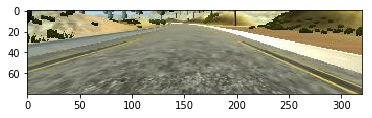

In [35]:
print(x.shape)
plt.imshow(x[0])

In [40]:
model.fit(dataset,
          epochs=EPOCHS,
          steps_per_epoch=steps_per_epoch,
          validation_data=val_dataset,
          validation_steps=1)

Epoch 1/10
111/111 [==============================] - 47s 427ms/step - loss: 0.0100 - mean_absolute_error: 0.0791 - val_loss: 0.0081 - val_mean_absolute_error: 0.0778
Epoch 2/10
111/111 [==============================] - 46s 419ms/step - loss: 0.0098 - mean_absolute_error: 0.0791 - val_loss: 0.0068 - val_mean_absolute_error: 0.0690
Epoch 3/10
111/111 [==============================] - 49s 438ms/step - loss: 0.0102 - mean_absolute_error: 0.0801 - val_loss: 0.0094 - val_mean_absolute_error: 0.0730
Epoch 4/10
111/111 [==============================] - 49s 440ms/step - loss: 0.0086 - mean_absolute_error: 0.0736 - val_loss: 0.0075 - val_mean_absolute_error: 0.0743
Epoch 5/10
111/111 [==============================] - 49s 440ms/step - loss: 0.0083 - mean_absolute_error: 0.0719 - val_loss: 0.0063 - val_mean_absolute_error: 0.0658
Epoch 6/10
111/111 [==============================] - 50s 451ms/step - loss: 0.0081 - mean_absolute_error: 0.0711 - val_loss: 0.0119 - val_mean_absolute_error: 0.092

In [42]:
tf.keras.models.save_model(
    model,
    "models/test3"
)